In [1]:
# Guoqiang Tang
# Train period metrics: reading metrics from Ostrich output files
# Test period metrics: calculating from netcdf simulations
# (1) Optimized parameter: Simulations from 1951 to 2019 using finit from 1951 to the beginning of calibration periods
# (2) Default parameter: Spin up outputs using default finit at 2000-01-01. Spin up has model outputs from 1951 to the beginning of calibration periods


import numpy as np
import datetime
import xarray as xr
import pandas as pd
import sys, glob, os, re, subprocess, toml
import matplotlib
import matplotlib.pyplot as plt

# turn off all warnings (not always necessary)
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '../../src/Ostrich_support')
from cal_metrics_NoRouting import *

def count_folders_in_directory(directory):
    return sum(os.path.isdir(os.path.join(directory, entry)) for entry in os.listdir(directory))


# Load basin information

In [2]:
basins = []
for i in range(627):
    basins.append(f'level1_{i}')
    
for i in range(40):
    basins.append(f'level2_{i}')
    
for i in range(4):
    basins.append(f'level3_{i}')

In [3]:
levelnum = np.array([int(i[5]) for i in basins])
basinnum = np.array([int(i.split('_')[1]) for i in basins])

In [4]:
filesinfo = ['/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv', 
             '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/data_mesh_surf/HillslopeHydrology/CAMELS_level2_basin_info.csv',
             '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/data_mesh_surf/HillslopeHydrology/CAMELS_level3_basin_info.csv']

cols = ['hru_id', 'lon_cen', 'lat_cen', 'elev_mean', 'latoutlet', 'lonoutlet', 'areaUSGS']
basininfo = np.nan * np.zeros([len(levelnum), len(cols)]) # lat, lon, areaUSGS
flag = 0
for i in range(3):
    dfi = pd.read_csv(filesinfo[i])
    basinnumi = basinnum[levelnum==i+1]
    for j in range(len(basinnumi)):
        basininfo[flag, :] = dfi.loc[basinnumi[j], cols].values
        flag = flag + 1

# Load Metrics

In [5]:
outfile_metric = 'train_test_metric.npz'

## Load train periods

In [6]:
# infiles
inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich'
# infilelist_stat = glob.glob(f'{inpath}/level*_Ostrich/archive/PreserveBestModel/trial_stats_allrecords.txt')
# infilelist_stat.sort()
infilelist_stat = [f'{inpath}/{i}_Ostrich/archive/PreserveBestModel/trial_stats_allrecords.txt' for i in basins]
print('The number of stat files:', len(infilelist_stat))

# infilelist_ostmodel = glob.glob(f'{inpath}/level*_Ostrich/archive/PreserveBestModel/OstModel0.txt')
# infilelist_ostmodel.sort()
infilelist_ostmodel = [f'{inpath}/{i}_Ostrich/archive/PreserveBestModel/OstModel0.txt' for i in basins]
print('The number of OstModel0.txt files:', len(infilelist_stat))

The number of stat files: 671
The number of OstModel0.txt files: 671


In [7]:
def read_trial_stats_allrecords(file_path):
    kge_values = []
    rmse_values = []
    with open(file_path, 'r') as file:
        for line in file:
            if '#streamflow_KGE' in line:
                kge_value = float(line.split('#')[0].strip())
                kge_values.append(kge_value)
            elif '#streamflow_RMSE' in line:
                rmse_value = float(line.split('#')[0].strip())
                rmse_values.append(rmse_value)
    return np.array(kge_values), np.array(rmse_values)

if not os.path.isfile(outfile_metric):

    # Metrics from OstModel0.txt
    num = len(infilelist_ostmodel)
    kge_ost = np.nan * np.zeros([num, 2]) # default param kge and best param kge

    for i in range(num):
        infile_OstModel = infilelist_ostmodel[i]
        df_OstModel = pd.read_csv(infile_OstModel, delim_whitespace=True)
        df_OstModel['obj.function'] = df_OstModel['obj.function'].values.astype(float) # some times there is NaN string
        kge_ost[i, 0] = -df_OstModel['obj.function'].values[0]
        kge_ost[i, 1] = -df_OstModel['obj.function'].values[-1]
        
    # Metrics from trial_stats_allrecords.txt
    num = len(infilelist_ostmodel)
    kge_stat = np.nan * np.zeros([num, 2]) # default param kge and best param kge
    rmse_stat = np.nan * np.zeros([num, 2]) # default param kge and best param kge

    for i in range(num):
        infile_stat = infilelist_stat[i]
        tmpkge, tmprmse = read_trial_stats_allrecords(infile_stat)

        kge_stat[i, 0] = tmpkge[0]
        kge_stat[i, 1] = tmpkge[-1]

        rmse_stat[i, 0] = tmprmse[0]
        rmse_stat[i, 1] = tmprmse[-1]
        
    # check whether OstModel0.txt and trial_stats_allrecords.txt agree with each other
    if np.any( np.abs(kge_stat-kge_ost) > 1e-3):
        print('OstModel0.txt and trial_stats_allrecords.txt does not agree for some basins')
    else:
        print('OstModel0.txt and trial_stats_allrecords.txt agree with each other for all basins')
        
    # assign variables
    kge_train_optm = kge_stat[:,1]
    kge_train_defa = kge_stat[:,0]
    rmse_train_optm = rmse_stat[:,1]
    rmse_train_defa = rmse_stat[:,0]

## Load test period (calculation from netcdf outputs)

### Get the train period

In [8]:
train_startdate = []
inpath = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Calib_all_HH_Ostrich/configuration'
for b in basins:
    b = b.replace('_', '-')
    file = f'{inpath}/_{b}_config_Ostrich.toml'
    config = toml.load(file)
    train_startdate.append(config['RUN_STARTDATE'])
train_startdate = pd.to_datetime(train_startdate)

In [9]:
testyears = 5

test_startdate = train_startdate - pd.offsets.DateOffset(years=testyears)
test_enddate = train_startdate - pd.offsets.DateOffset(days=1)


### Test period: Optmized parameters

In [10]:
if not os.path.isfile(outfile_metric):

    kge_test_optm = np.nan * np.zeros(len(basins))
    rmse_test_optm = np.nan * np.zeros(len(basins))

    for i in range(len(basins)):
        if np.mod(i, 100)==0:
            print(i)

        basin = basins[i]

        ######## required input arguments
        pathCTSM = f'/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}'
        # path_archive = f'/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}_Ostrich/archive/PreserveModelOutput/Run_58'
        # path_archive = f'/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}_Ostrich/archive/PreserveBestModel/'
        path_archive = f'/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}_Ostrich/archive/Bestsimu1/'
        date_start = test_startdate[i].strftime('%Y-%m-%d')
        date_end = test_enddate[i].strftime('%Y-%m-%d')

        # reference files (streamflow, snow cover). if a file cannot be found, it won't be inclulded in the calibration
        ref_streamflow = f'/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}_Ostrich/refdata/streamflow_data.csv'

        # add_flow_file. sometimes upstream flow needs to be added to the incremental downstream area runoff
        add_flow_file = ''


        ######## default variable names
        clm_q_name = 'QRUNOFF' # default runoff variable name
        clm_q_sdim = 'lndgrid' # spatial dim name
        ref_q_name = 'Runoff_cms'
        ref_q_date = 'Date'
        keyword = ".clm2.h1."

        ########################################################################################################################
        # load CTSM streamflow (m3/s)
        CTSMfilelist = []
        year1 = int(date_start[:4])
        year2 = int(date_end[:4])
        for y in range(year1-1, year2+2):
            CTSMfilelist = CTSMfilelist + glob.glob(f'{path_archive}/*.h1.{y}*.nc')
        CTSMfilelist.sort()

        ds_simu = main_read_CTSM_streamflow(pathCTSM, CTSMfilelist, date_start, date_end, clm_q_name, clm_q_sdim)

        ########################################################################################################################
        # load CAMELS observation streamflow (m3/s)
        ds_q_obs = read_CAMELS_Q_and_to_xarray(ref_streamflow, ref_q_date, ref_q_name)

        ########################################################################################################################
        # add upstream flows to simulated streamflow
        ds_simu = add_upstream_flow(add_flow_file, ds_simu, ref_q_date, ref_q_name, clm_q_name)

        ########################################################################################################################
        # evaluation

        ds_q_obs = ds_q_obs.sel(time=ds_q_obs.time.isin(ds_simu.time))
        ds_simu = ds_simu.sel(time=ds_simu.time.isin(ds_q_obs.time))

        kge_q = get_modified_KGE(obs=ds_q_obs[ref_q_name].values, sim=ds_simu[clm_q_name].values)
        rmse_q = get_RMSE(obs=ds_q_obs[ref_q_name].values, sim=ds_simu[clm_q_name].values)

        kge_test_optm[i] = kge_q
        rmse_test_optm[i] = rmse_q

### Test period: default parameters

In [11]:
if not os.path.isfile(outfile_metric):
    kge_test_defa = np.nan * np.zeros(len(basins))
    rmse_test_defa = np.nan * np.zeros(len(basins))

    for i in range(len(basins)):
        if np.mod(i, 100)==0:
            print(i)

        basin = basins[i]

        ######## required input arguments
        pathCTSM = f'/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}'
        # path_archive = f'/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}_Ostrich/archive/PreserveModelOutput/Run_58'
        # path_archive = f'/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}_Ostrich/archive/PreserveBestModel/'
        # path_archive = f'/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}_Ostrich/archive/Bestsimu1/'
        path_archive = f'/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Calib_all_HH_MOASMO/{basin}_SpinupFiles/archive/lnd/hist'


        date_start = test_startdate[i].strftime('%Y-%m-%d')
        date_end = test_enddate[i].strftime('%Y-%m-%d')

        # reference files (streamflow, snow cover). if a file cannot be found, it won't be inclulded in the calibration
        ref_streamflow = f'/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}_Ostrich/refdata/streamflow_data.csv'

        # add_flow_file. sometimes upstream flow needs to be added to the incremental downstream area runoff
        add_flow_file = ''


        ######## default variable names
        clm_q_name = 'QRUNOFF' # default runoff variable name
        clm_q_sdim = 'lndgrid' # spatial dim name
        ref_q_name = 'Runoff_cms'
        ref_q_date = 'Date'
        keyword = ".clm2.h1."

        ########################################################################################################################
        # load CTSM streamflow (m3/s)
        CTSMfilelist = []
        year1 = int(date_start[:4])
        year2 = int(date_end[:4])
        for y in range(year1-1, year2+2):
            CTSMfilelist = CTSMfilelist + glob.glob(f'{path_archive}/*.h1.{y}*.nc')
        CTSMfilelist.sort()

        ds_simu = main_read_CTSM_streamflow(pathCTSM, CTSMfilelist, date_start, date_end, clm_q_name, clm_q_sdim)

        ########################################################################################################################
        # load CAMELS observation streamflow (m3/s)
        ds_q_obs = read_CAMELS_Q_and_to_xarray(ref_streamflow, ref_q_date, ref_q_name)

        ########################################################################################################################
        # add upstream flows to simulated streamflow
        ds_simu = add_upstream_flow(add_flow_file, ds_simu, ref_q_date, ref_q_name, clm_q_name)

        ########################################################################################################################
        # evaluation

        ds_q_obs = ds_q_obs.sel(time=ds_q_obs.time.isin(ds_simu.time))
        ds_simu = ds_simu.sel(time=ds_simu.time.isin(ds_q_obs.time))

        kge_q = get_modified_KGE(obs=ds_q_obs[ref_q_name].values, sim=ds_simu[clm_q_name].values)
        rmse_q = get_RMSE(obs=ds_q_obs[ref_q_name].values, sim=ds_simu[clm_q_name].values)

        kge_test_defa[i] = kge_q
        rmse_test_defa[i] = rmse_q

## save metrics

In [12]:
if not os.path.isfile(outfile_metric):
    np.savez_compressed(outfile_metric, kge_train_optm=kge_train_optm, kge_train_defa=kge_train_defa, kge_test_optm=kge_test_optm, kge_test_defa=kge_test_defa, 
                        rmse_train_optm=rmse_train_optm, rmse_train_defa=rmse_train_defa, rmse_test_optm=rmse_test_optm, rmse_test_defa=rmse_test_defa, 
                        test_startdate=test_startdate, test_enddate=test_enddate)
else:
    dtmp = np.load(outfile_metric)
    kge_train_optm=dtmp['kge_train_optm']
    kge_train_defa=dtmp['kge_train_defa']
    kge_test_optm=dtmp['kge_test_optm']
    kge_test_defa=dtmp['kge_test_defa']
    rmse_train_optm=dtmp['rmse_train_optm']
    rmse_train_defa=dtmp['rmse_train_defa']
    rmse_test_optm=dtmp['rmse_test_optm']
    rmse_test_defa=dtmp['rmse_test_defa']
    test_startdate=dtmp['test_startdate']
    test_enddate=dtmp['test_enddate']

In [15]:
print(np.nanmedian(kge_train_optm), np.nanmedian(kge_train_defa), np.nanmedian(kge_test_optm), np.nanmedian(kge_test_defa))

0.456552 0.149327 0.3909587743989119 0.15403147830810326


# Plot

In [89]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax

## KGE map

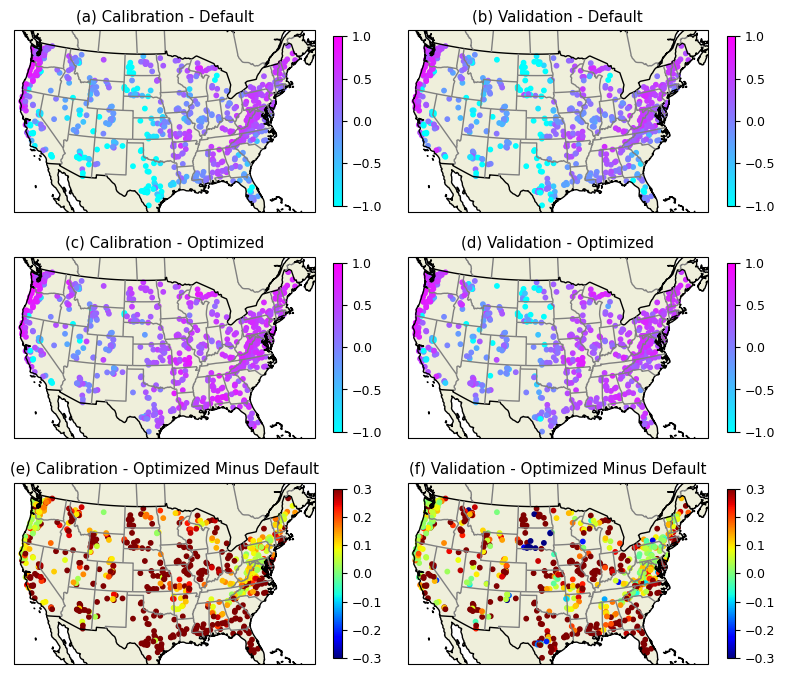

In [136]:
data = [kge_train_defa, kge_test_defa, 
        kge_train_optm, kge_test_optm, 
        kge_train_optm - kge_train_defa, kge_test_optm - kge_test_defa]

title = ["(a) Calibration - Default", "(b) Validation - Default", 
         "(c) Calibration - Optimized", "(d) Validation - Optimized",
         "(e) Calibration - Optimized Minus Default", "(f) Validation - Optimized Minus Default",]
cmaps = ['cool', 'cool', 
         'cool', 'cool', 
         'jet', 'jet']
lims = [ [-1, 1], [-1, 1], 
        [-1, 1], [-1, 1], 
        [-0.3, 0.3], [-0.3, 0.3]]


font = {'size'   : 9}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[8, 7])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(6):
    ax = fig.add_subplot(3, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(basininfo[:,1], basininfo[:, 2], 10, data[i], cmap=cmaps[i], vmin=lims[i][0], vmax=lims[i][1], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='right', shrink=0.8)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


plt.tight_layout()
plt.savefig('KGE_defa_optm.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()

## RMSE map

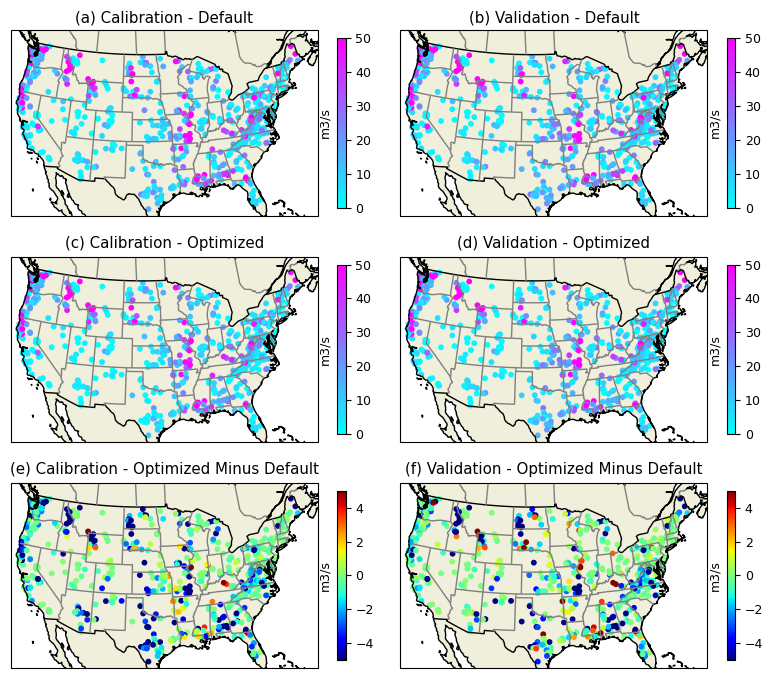

In [135]:
data = [rmse_train_defa, rmse_test_defa, 
        rmse_train_optm, rmse_test_optm, 
        rmse_train_optm - rmse_train_defa, rmse_test_optm - rmse_test_defa]

title = ["(a) Calibration - Default", "(b) Validation - Default", 
         "(c) Calibration - Optimized", "(d) Validation - Optimized",
         "(e) Calibration - Optimized Minus Default", "(f) Validation - Optimized Minus Default",]
cmaps = ['cool', 'cool', 
         'cool', 'cool', 
         'jet', 'jet']
lims = [ [0, 50], [0, 50], 
        [0, 50], [0, 50], 
        [-5, 5], [-5, 5]]
labels = ['m3/s', 'm3/s', 'm3/s', 'm3/s', 'm3/s', 'm3/s']


font = {'size'   : 9}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[8, 7])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(6):
    ax = fig.add_subplot(3, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(basininfo[:,1], basininfo[:, 2], 10, data[i], cmap=cmaps[i], vmin=lims[i][0], vmax=lims[i][1], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='right', shrink=0.8, )
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')
    cax.set_label(labels[i], loc='center')


plt.tight_layout()
plt.savefig('RMSE_defa_optm.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()

## Hist of differences

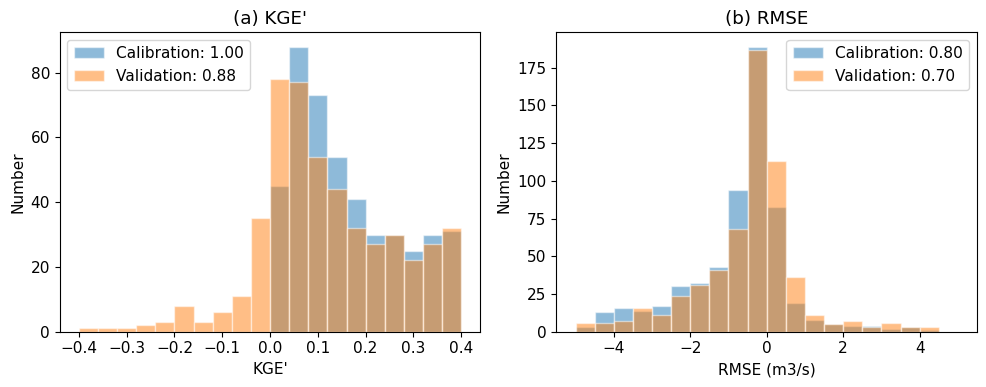

In [142]:
d1 = [kge_train_optm-kge_train_defa, rmse_train_optm - rmse_train_defa]
d2 = [kge_test_optm-kge_test_defa, rmse_test_optm - rmse_test_defa]

ratio = [ [np.sum(d1[0]>0)/np.sum(~np.isnan(d1[0])), np.sum(d2[0]>0)/np.sum(~np.isnan(d2[0]))], 
         [np.sum(d1[1]<0)/np.sum(~np.isnan(d1[1])), np.sum(d2[1]<0)/np.sum(~np.isnan(d2[1]))], 
        ]


limits = [ np.arange(-0.4, 0.4+0.04, 0.04),  np.arange(-5, 5+0.5, 0.5)]

titles = ["(a) KGE'", "(b) RMSE"]
xlabs = ["KGE'", "RMSE (m3/s)"]

# project and transform defintions
font = {'size'   : 11}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, 4])

for i in range(len(d1)):
    ax= fig.add_subplot(1, 2, i+1)
    
    labs = ['Calibration', 'Validation']
    for j in range(2):
        labs[j] = f"{labs[j]}: {ratio[i][j]:.2f}"
    
    ax.hist(d1[i], limits[i], alpha=0.5, ec="white", label=labs[0])
    ax.hist(d2[i], limits[i], alpha=0.5, ec="white", label=labs[1])
    
    ax.set_title(titles[i])
    ax.legend()
    ax.set_ylabel('Number')
    ax.set_xlabel(xlabs[i])
    
plt.tight_layout()
# plt.subplots_adjust(hspace=-0.3)
# plt.savefig('KGE_RMSE_diff_hist.png', dpi=600, facecolor='w', bbox_inches='tight',pad_inches = 0)
# plt.show()